<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/CIFAR_QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 5.1MB/s 
     |████████████████████████████████| 18.0MB 154kB/s 
     |████████████████████████████████| 235kB 50.7MB/s 
     |████████████████████████████████| 215kB 51.0MB/s 
     |████████████████████████████████| 2.1MB 33.6MB/s 
     |████████████████████████████████| 1.5MB 36.7MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 194kB 52.4MB/s 
     |████████████████████████████████| 112kB 44.4MB/s 
     |████████████████████████████████| 614kB 27.2MB/s 
     |████████████████████████████████| 3.2MB 37.1MB/s 
     |████████████████████████████████| 6.3MB 34.3MB/s 
  Created wheel for qiskit: filename=qiskit-0.26.2-cp37-none-any.whl size=10506 sha256=12f51dc2d377a6044ff38d97d797ca61b1047760ecd2ce0e6114cc12c4fe2642
  Stored in directory: /root/.cache/pip/wheels/89/89/34/524839952d5a58a7be9789e580bfc1ca883bf6579152444568
  Created wheel for python-constraint: filename=python_constraint-1.4.0-

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [4]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [5]:
class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

In [6]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value]) # store the result as a torch tensor
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        # Obtain paramaters 
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s  # Shift up by s
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s # Shift down by s
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

In [25]:
#import torchvision
#transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
#cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

#labels = cifar_trainset.targets # get the labels for the data
#labels = labels.numpy()

#idx1 = np.where(labels == 0) # filter on aeroplanes
#idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
#n=100

# concatenate the data indices
#idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
#cifar_trainset.targets = labels[idx] 
#cifar_trainset.data = cifar_trainset.data[idx]

#train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)

Files already downloaded and verified


AttributeError: ignored

In [15]:
import tensorflow
import torchvision

In [26]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [8]:

import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


Now creating the hybrid neural network.

In [31]:

qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.h1 = nn.Linear(500, 500)
        self.h2 = nn.Linear(500, 1)

    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.h1(x))
        x = F.dropout(x, training=self.training)
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  # Normalise the inputs to 1 or 0
        x = torch.cat((x, 1-x), -1)
        return x

-0.5160500000000002
-0.5147499999999998
-0.4957500000000001
-0.5060999999999997
-0.5278
-0.5152499999999998
-0.5463500000000002
-0.6112999999999998
-0.6389999999999998
-0.6592499999999994


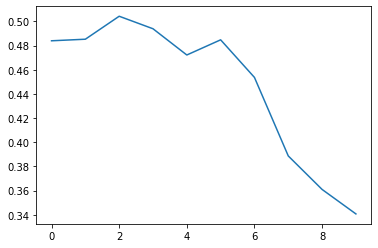

In [32]:
network = Net()
#input = input.permute(1,0,2,3)
optimizer = optim.Adam(network.parameters(), lr=0.001)

epochs = 10
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1])

# Normalise the loss between 0 and 1
for i in range(len(loss_list)):
    loss_list[i] += 1

# Plot the loss per epoch
plt.plot(loss_list)

In [18]:

import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline